# Improve Global Cross correlation

:::{note}
This is a note
:::


The [Goodman Pipeline](https://soardocs.readthedocs.io/projects/goodman-pipeline/en/latest/), in order to perform a wavelength calibration it uses a comparison lamp obtained with the same instrumental configuration as the science target and a reference lamp from a library of previously wavelength-calibrated comparison lamps. To compare them and make a match, first it has to be selected according to a series of criteria based on information on the lamp's header. Now, the actual calibration goes like this: First, find the *global cross correlation first*, this is how shifted the new comparison lamp is with respect to the reference lamp. It is normal to have some pixels displacement, due to environmental differences and telescope flexure. The difference in time may also have an impact in the shape of the features. Then, depending on the number of (say N) lines, the full spectrum is split in N parts that are also cross correlated. This is called a *local cross correlation*

The global cross correlation is used as a reference, this means that if a local cross correlation deviates too much from the global correlation that point is discarded from the list of points that later will be used to fit the wavelength solution model.

The problem that was encounter is that the new lamp is very different to the old one and for some reason the global cross correlation gives very big numbers. For example -700 when it should be greater than 50 or 100 en extreme cases. 


# Sample data

In [2]:
new_lamp = './fits/ecfzst_0177_comp_600m_359.58-405.87.fits'
ref_lamp = './fits/goodman_comp_600Mid_GG385_HgArNe.fits'

In [3]:
from ccdproc import CCDData
import matplotlib.pyplot as plt

from goodman_pipeline.wcs import WCS
from goodman_pipeline.core import bin_reference_data, cross_correlation

wcs = WCS()

Failed to import any qt binding


In [4]:
new = CCDData.read(new_lamp, unit='adu')
ref = CCDData.read(ref_lamp, unit='adu')


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [5]:
ref_w_ax, ref.data = wcs.read_gsp_wcs(ccd=ref)

ref_w_ax, ref.data = bin_reference_data(wavelength=ref_w_ax, intensity=ref.data, serial_binning=2)

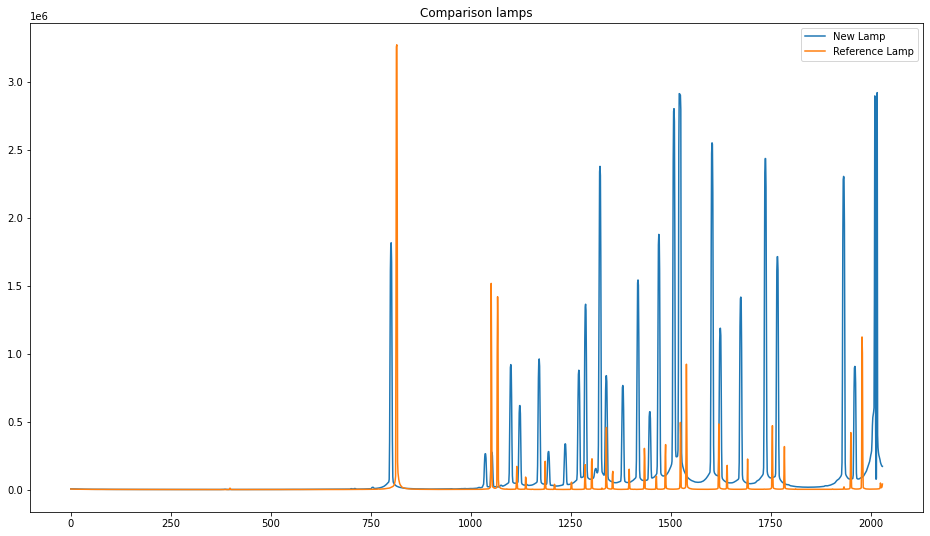

In [6]:
fig, ax = plt.subplots(figsize=(16,9))
ax.set_title("Comparison lamps")
ax.plot(new.data, label='New Lamp')
ax.plot(ref.data, label='Reference Lamp')
plt.legend(loc='best')

Using the cross correlation function results in this plot below. This is clearly not the expected result.

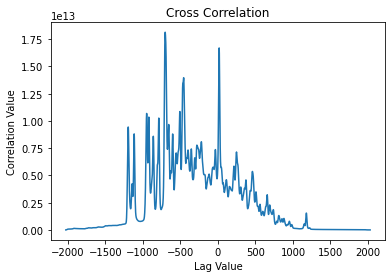

<Figure size 432x288 with 0 Axes>

In [7]:
import re
slit_size = float(re.sub('["A-Za-z_ ]', '', new.header['SLIT']))
global_cross_correlation = cross_correlation(reference=ref.data, compared=new.data, slit_size=slit_size, serial_binning=2, plot=True)

# Modifications to the function

I'll just copy and paste the original function here and then modify it.

In [8]:
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
from astropy.modeling import models
from scipy import signal
import numpy as np

In [9]:
def cross_correlation_2(reference,
                      compared,
                      slit_size,
                      serial_binning,
                      preference='none',
                      mode='full',
                      plot=False):
    """Do cross correlation of two 1D spectra

    It convolves the reference lamp depending on the slit size of the new_array
    that corresponds with a comparison lamp.
    If the slit is larger than 3 arcseconds the reference lamp is convolved with
    a `~astropy.convolution.Box1DKernel` because spectral lines look more like a
    block than a line. And if it is smaller or equal to 3 it will
    use a `~astropy.convolution.Gaussian1DKernel` ponderated by the binning.
    All reference lamp are unbinned, or binning is 1x1.

    Args:
        reference (array): Reference array.
        compared (array): Array to be matched. A new reference lamp.
        slit_size (float): Slit width in arcseconds
        serial_binning (int): Binning in the spectral axis
        mode (str): Correlation mode for `signal.correlate`.
        plot (bool): Switch debugging plots on or off.

    Returns:
        correlation_value (int): Shift value in pixels.

    """
    cyaxis2 = compared
    if slit_size > 3:

        box_width = slit_size / (0.15 * serial_binning)

        log.debug('BOX WIDTH: {:f}'.format(box_width))
        box_kernel = Box1DKernel(width=box_width)
        max_before = np.max(reference)
        cyaxis1 = convolve(reference, box_kernel)
        max_after = np.max(cyaxis1)
        cyaxis1 *= max_before / max_after

    else:
        kernel_stddev = slit_size / (0.15 * serial_binning)

        gaussian_kernel = Gaussian1DKernel(stddev=kernel_stddev)
        cyaxis1 = convolve(reference, gaussian_kernel)
        cyaxis2 = convolve(compared, gaussian_kernel)

    ccorr = signal.correlate(cyaxis1, cyaxis2, mode=mode)
        
    gaussian_model = models.Gaussian1D(amplitude=1, mean=len(ccorr)/2., stddev=50)
 

    x_ccorr = np.linspace(-int(len(ccorr) / 2.),
                              int(len(ccorr) / 2.),
                              len(ccorr))
    if preference == 'center':
        gaussian_model = models.Gaussian1D(amplitude=1, mean=len(ccorr)/2., stddev=50)
        gaussian_weights = gaussian_model(range(len(x_ccorr)))
        gaussian_weighted = gaussian_weights * ccorr
 
        max_index = np.argmax(gaussian_weighted)
    elif preference == 'none':
        max_index = np.argmax(ccorr)
        
    else:
        raise NotImplementedError(f"'preference' {preference} is not valid. Options are 'none' and 'center'")
    
    correlation_value =  x_ccorr[max_index]    
        
    print(f"Found correlation value of {correlation_value}")
    
    
    if plot:  # pragma: no cover
#         plt.ion()
        plt.title('Cross Correlation')
        plt.xlabel('Lag Value')
        plt.ylabel('Correlation Value')
        plt.plot(x_ccorr, ccorr, label='Original Cross Correlation')
        if preference == 'center':
            plt.plot(x_ccorr, gaussian_weights, label="Centered Gaussian")
            plt.plot(x_ccorr, gaussian_weighted, label='Gaussian Weighted')
        plt.legend(loc='best')
        plt.draw()
#         plt.pause(2)
#         plt.clf()
#         plt.ioff()
    return correlation_value

Found correlation value of 15.0


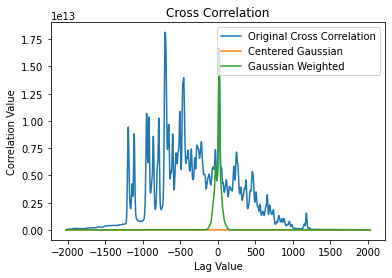

In [10]:
global_cross_correlation = cross_correlation_2(reference=ref.data, compared=new.data, slit_size=slit_size, serial_binning=2, preference='center', plot=True)

# What was done?

I created a gaussian weight distribution, centered in 0. This is correct because this function is used with arrays that are expected to have a *best correlation* near the central value. (Zero lag in this case). The standard deviation parameter of the gaussian function was set to 50 but it could be configured as an optional parameter to "tighten" or "relax" the center-heavy weight distribution. Also is important to note that this only should be used for the global cross correlation and not for the local cross correlation as it would impede to perform the intended task. If we encounter similar issues in the local *realm* then the whole solution is wrong.

# Some Tests
- [ ] Sensitivity tests

## Weights

In [20]:
weights_model = models.Gaussian1D(amplitude=1, mean=0, stddev=50)
x_axis = np.linspace(-1000, 1000, 2000)

weights = weights_model(x_axis)

## Sample Data


In [21]:
peak_positions = [-800, -300, -100]
peak_value = [100, 50, 30]


data = np.zeros(len(x_axis))
for i in range(3):
    peak_model = models.Lorentz1D(amplitude=peak_value[i], x_0=peak_positions[i], fwhm=10)
    data += peak_model(x_axis)
    

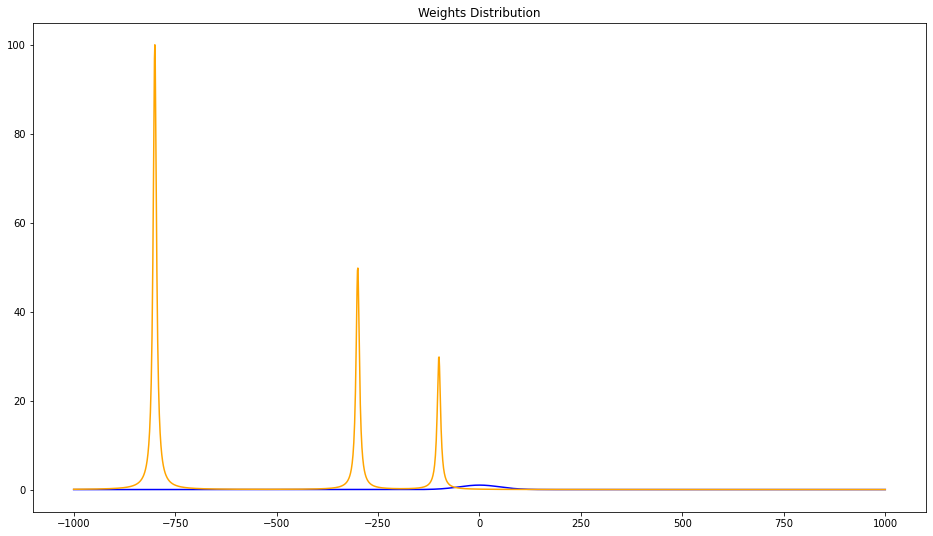

In [27]:
fig, ax = plt.subplots(figsize=(16,9))
ax.set_title("Weights Distribution")

ax.plot(x_axis, weights, color='b')
ax.plot(x_axis, data, color='orange')

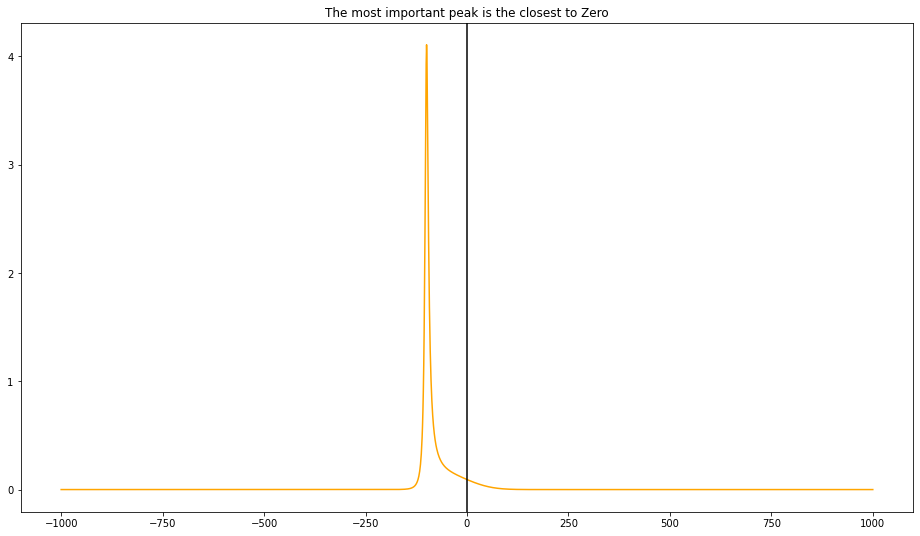

In [28]:
fig, ax = plt.subplots(figsize=(16,9))
ax.set_title("The most important peak is the closest to Zero")
ax.plot(x_axis, data * weights, color='orange')
ax.axvline(0, color='k', label="Zero")